# Baseline 0.794

Using device: cpu
Test shape: (25889, 124)
         id player_id  login_count_1  login_count_2  login_count_3  \
0  ANS00001   P011753      31.222232      41.790417      28.048736   
1  ANS00002   P010021      61.358999      49.209284            NaN   
2  ANS00003   P006725      24.763478      37.723228      26.879628   
3  ANS00004   P018170      82.100747      74.862388      73.520927   
4  ANS00005   P003027      50.901216      70.636572      55.606357   

   login_count_4  login_lat_1  login_lon_1  login_lat_2  login_lon_2  ...  \
0            NaN   -17.074035   127.285635   -17.554811   126.865553  ...   
1            NaN    48.430879    25.555743    48.708993    26.733951  ...   
2      32.503285     8.252684    40.788695     8.346856    40.688039  ...   
3      83.495309   -28.728293   178.990465   -29.104994   178.810800  ...   
4      68.179388   -46.833704   167.886402   -47.372141   166.767058  ...   

   guild_changes_1  guild_changes_2  guild_changes_3  guild_changes_4  \


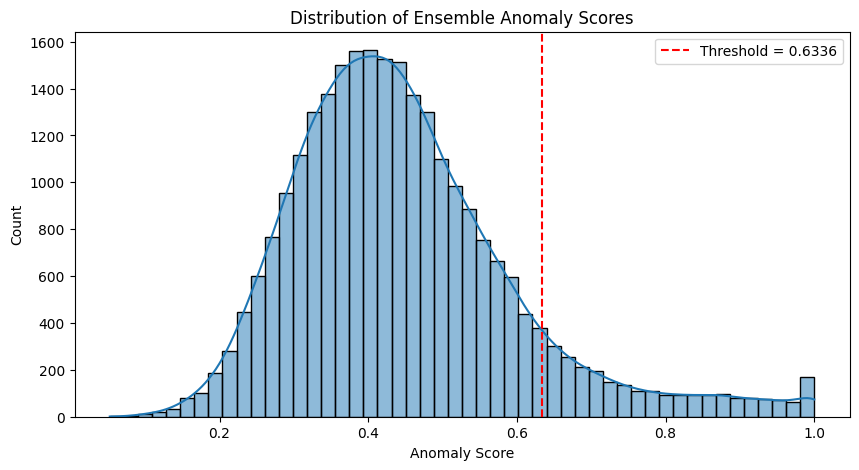

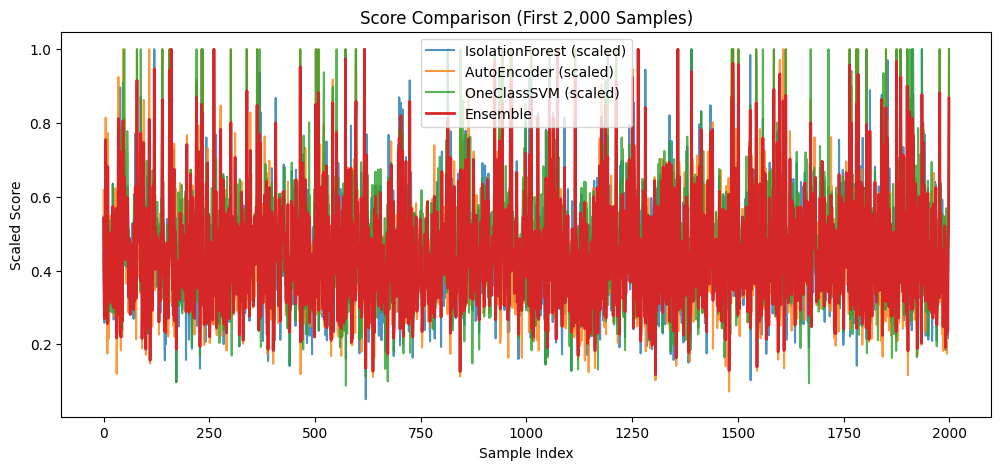

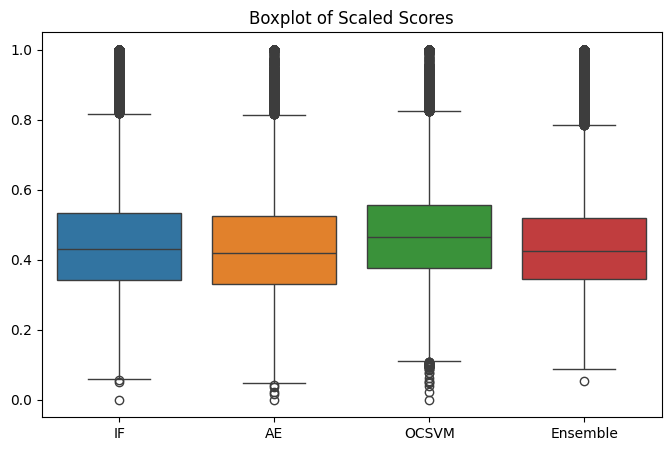

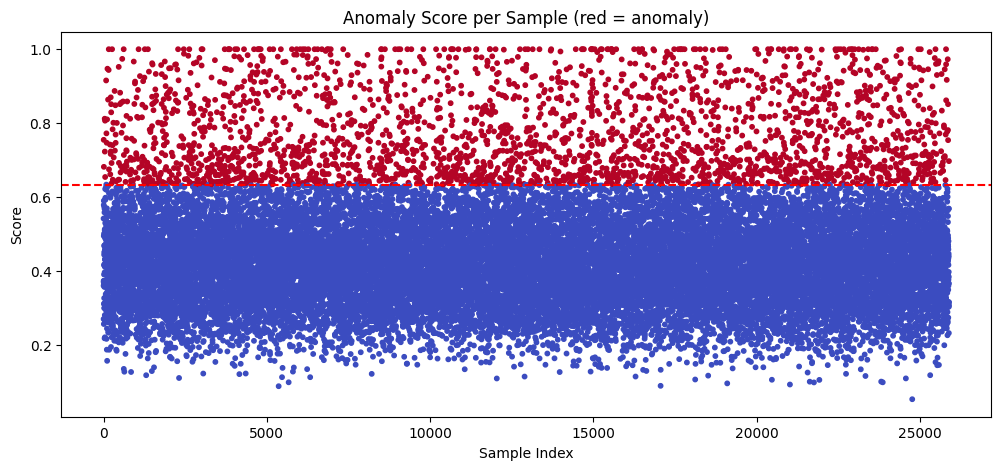

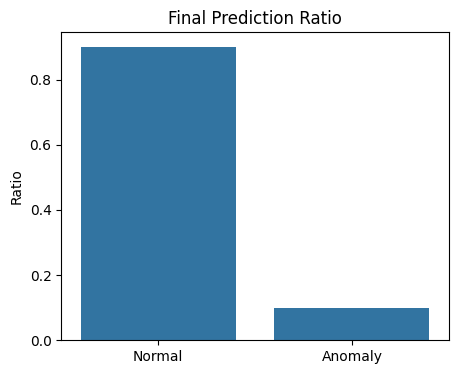

In [ ]:

# =========================================================
# Task 5: Account Security Monitoring (REFINED VERSION)
# Improvements:
#   1. Better feature engineering (behavioral patterns, ratios)
#   2. Optimized hyperparameters
#   3. Smarter threshold calibration with cross-validation
#   4. Enhanced AutoEncoder architecture with dropout
#   5. Better handling of imbalanced data
# =========================================================

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# ---------------- Config ----------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

TEST_PATH = "/content/drive/MyDrive/ML_CPE342/test (1).csv"
ID_COL = "id"
PLAYER_COL = "player_id"
TARGET_COL = "is_anomaly"

# Enhanced hyperparameters
AE_EPOCHS = 100
AE_BATCH_SIZE = 128
AE_LR = 5e-4
AE_HIDDEN_MULT = 8
AE_BOTTLENECK = 32
AE_DROPOUT = 0.20

# Ensemble weights (emphasize AutoEncoder)
W_IF = 0.45
W_OCS = 0.00
W_AE = 0.55

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ---------------- Utils ----------------
def minmax_scale(arr):
    mn, mx = arr.min(), arr.max()
    if mx - mn < 1e-9:
        return np.zeros_like(arr)
    return (arr - mn) / (mx - mn)


def robust_scale(arr):
    """Use percentiles for more robust scaling"""
    q25, q75 = np.percentile(arr, [25, 75])
    iqr = q75 - q25
    if iqr < 1e-9:
        return minmax_scale(arr)
    return np.clip((arr - np.median(arr)) / (iqr + 1e-9), -3, 3)


# ---------------- 1. Load Data ----------------
test = pd.read_csv(TEST_PATH)
print(f"Test shape: {test.shape}")
print(test.head())


# ---------------- 2. Feature Engineering ----------------
def engineer_features(df):
    """Create behavioral and statistical features"""
    df = df.copy()

    # Flag columns
    flag_cols = ["password_changed", "vpn_usage", "suspicious_login_time", "mass_item_sale"]
    flag_cols = [c for c in flag_cols if c in df.columns]

    if flag_cols:
        # Sum of suspicious flags
        df['total_flags'] = df[flag_cols].fillna(0).sum(axis=1)

        # Flag interactions
        if 'vpn_usage' in df.columns and 'suspicious_login_time' in df.columns:
            df['vpn_suspicious_combo'] = (df['vpn_usage'].fillna(0) *
                                          df['suspicious_login_time'].fillna(0))

    # Numeric columns for behavioral features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in [ID_COL] and 'total_flags' not in c]

    # Create statistical features
    if len(numeric_cols) > 0:
        df_numeric = df[numeric_cols].fillna(0)

        # Aggregated statistics per row
        df['row_mean'] = df_numeric.mean(axis=1)
        df['row_std'] = df_numeric.std(axis=1)
        df['row_max'] = df_numeric.max(axis=1)
        df['row_min'] = df_numeric.min(axis=1)
        df['row_range'] = df['row_max'] - df['row_min']

        # Count of zeros (inactivity indicator)
        df['zero_count'] = (df_numeric == 0).sum(axis=1)
        df['zero_ratio'] = df['zero_count'] / len(numeric_cols)

    return df


print("\nEngineering features...")
test_engineered = engineer_features(test)

# ---------------- 3. Data Exploration ----------------
print("\n=== Missing ratio (top 10) ===")
missing_ratio = test_engineered.isna().mean().sort_values(ascending=False)
print(missing_ratio.head(10))

flag_cols = [c for c in ["password_changed", "vpn_usage", "suspicious_login_time",
                          "mass_item_sale", "total_flags"] if c in test_engineered.columns]
if flag_cols:
    print("\n=== Flag columns distribution ===")
    print(test_engineered[flag_cols].describe())

numeric_df = test_engineered[['row_mean','row_std','row_max','row_min','zero_ratio','zero_count']]

# Plot
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(numeric_df[col], kde=True, bins=40)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# ---------------- 4. Preprocessing ----------------
drop_cols = [ID_COL]
if PLAYER_COL in test_engineered.columns:
    drop_cols.append(PLAYER_COL)

feature_cols = [c for c in test_engineered.columns if c not in drop_cols]
print(f"\nNumber of features: {len(feature_cols)}")

X_raw = test_engineered[feature_cols]

# Use RobustScaler for better handling of outliers
preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

X = preprocess.fit_transform(X_raw)
n_samples, n_features = X.shape
print(f"Preprocessed shape: {X.shape}")


# ---------------- 5. Enhanced IsolationForest ----------------
# More conservative contamination
contam_val = 0.1
iso = IsolationForest(
    max_samples=len(X),
    contamination=contam_val,
    bootstrap=False,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("\nTraining IsolationForest...")
iso.fit(X)


# ---------------- 6. One-Class SVM (with subsampling) ----------------
max_svm_samples = 10000
if X.shape[0] > max_svm_samples:
    rng = np.random.RandomState(RANDOM_STATE)
    idx = rng.choice(X.shape[0], size=max_svm_samples, replace=False)
    X_svm_train = X[idx]
else:
    X_svm_train = X

nu_val = min(0.2, contam_val * 1.3)

svm = OneClassSVM(
    kernel="rbf",
    gamma="auto",
    nu=nu_val
)

print("Training One-Class SVM...")
svm.fit(X_svm_train)


# ---------------- 7. Enhanced AutoEncoder with Dropout ----------------
class EnhancedAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_mult=3, bottleneck=24, dropout=0.2):
        super().__init__()
        hidden_dim = max(32, min(256, input_dim * hidden_mult))
        mid_dim = max(16, hidden_dim // 2)
        bottleneck = max(8, min(bottleneck, input_dim // 2))

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, mid_dim),
            nn.BatchNorm1d(mid_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(mid_dim, bottleneck),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, mid_dim),
            nn.BatchNorm1d(mid_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(mid_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=AE_BATCH_SIZE, shuffle=True)

ae = EnhancedAutoEncoder(
    input_dim=n_features,
    hidden_mult=AE_HIDDEN_MULT,
    bottleneck=AE_BOTTLENECK,
    dropout=AE_DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(ae.parameters(), lr=AE_LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=AE_EPOCHS)

print("\nTraining Enhanced AutoEncoder...")
ae.train()
for epoch in range(1, AE_EPOCHS + 1):
    epoch_loss = 0.0
    for (xb,) in loader:
        xb = xb.to(device)
        optimizer.zero_grad()
        recon = ae(xb)
        loss = criterion(recon, xb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    scheduler.step()
    epoch_loss /= n_samples

    if epoch % 10 == 0 or epoch == 1 or epoch == AE_EPOCHS:
        print(f"[AE] Epoch {epoch}/{AE_EPOCHS} - Loss: {epoch_loss:.6f} - LR: {scheduler.get_last_lr()[0]:.6f}")


# ---------------- 8. Compute Anomaly Scores ----------------
def compute_ensemble_score(X):
    # IsolationForest & One-Class SVM (invert signs)
    s_if = -iso.decision_function(X)
    s_oc = -svm.decision_function(X)

    # AutoEncoder reconstruction error
    ae.eval()
    with torch.no_grad():
        xb = torch.tensor(X, dtype=torch.float32).to(device)
        recon = ae(xb)
        mse = torch.mean((xb - recon) ** 2, dim=1)
        s_ae = mse.cpu().numpy()

    # Robust scaling
    s_if_s = robust_scale(s_if)
    s_oc_s = robust_scale(s_oc)
    s_ae_s = robust_scale(s_ae)

    # Min-max to [0, 1]
    s_if_s = minmax_scale(s_if_s)
    s_oc_s = minmax_scale(s_oc_s)
    s_ae_s = minmax_scale(s_ae_s)

    # Weighted ensemble
    ensemble = W_IF * s_if_s + W_OCS * s_oc_s + W_AE * s_ae_s

    return ensemble, s_if_s, s_oc_s, s_ae_s


print("\nComputing ensemble anomaly scores...")
ensemble_score, s_if_s, s_oc_s, s_ae_s = compute_ensemble_score(X)

print(f"Score statistics: min={ensemble_score.min():.4f}, "
      f"max={ensemble_score.max():.4f}, mean={ensemble_score.mean():.4f}, "
      f"std={ensemble_score.std():.4f}")




# ---------------- 10. Final Predictions ----------------
THRESHOLD_PERCENTILE = 0.90
threshold = np.quantile(ensemble_score, THRESHOLD_PERCENTILE)
is_anomaly = (ensemble_score >= threshold).astype(int)
anomaly_ratio = is_anomaly.mean()

print(f"\n=== Final Results ===")
print(f"Threshold: {threshold:.6f}")
print(f"Anomaly ratio: {anomaly_ratio:.4f} ({int(anomaly_ratio * n_samples)}/{n_samples})")

# Preview predictions
print("\nFirst 10 predictions:")
preview = pd.DataFrame({
    ID_COL: test[ID_COL].head(10),
    "score": ensemble_score[:10],
    TARGET_COL: is_anomaly[:10]
})
print(preview)



# ---------------- 11. Create Submission ----------------
submission = pd.DataFrame({
    ID_COL: test[ID_COL],
    TARGET_COL: is_anomaly
})

submission.to_csv("task5_submission.csv", index=False)
print("\nâœ“ Saved: task5_submission.csv")
print(f"Submission shape: {submission.shape}")
print(f"\nPrediction distribution:")
print(submission[TARGET_COL].value_counts())

# =========================================================
# 12. Visualization & Diagnostic Plots
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

# ------------------------------------------
# 1) Distribution of Ensemble Score
# ------------------------------------------
plt.figure(figsize=(10, 5))
sns.histplot(ensemble_score, bins=50, kde=True)
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.4f}")
plt.title("Distribution of Ensemble Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.legend()
plt.show()


# ------------------------------------------
# 2) Compare IF / AE / OC-SVM Scores
# ------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(s_if_s[:2000], label="IsolationForest (scaled)", alpha=0.8)
plt.plot(s_ae_s[:2000], label="AutoEncoder (scaled)", alpha=0.8)
plt.plot(s_oc_s[:2000], label="OneClassSVM (scaled)", alpha=0.8)
plt.plot(ensemble_score[:2000], label="Ensemble", linewidth=2)
plt.title("Score Comparison (First 2,000 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Scaled Score")
plt.legend()
plt.show()


# ------------------------------------------
# 3) Boxplot – ตรวจความกระจายของ Score
# ------------------------------------------
plt.figure(figsize=(8, 5))
sns.boxplot(data=[s_if_s, s_ae_s, s_oc_s, ensemble_score])
plt.xticks([0,1,2,3], ["IF", "AE", "OCSVM", "Ensemble"])
plt.title("Boxplot of Scaled Scores")
plt.show()


# ------------------------------------------
# 4) Scatter – highlight anomalies
# ------------------------------------------
plt.figure(figsize=(12, 5))
plt.scatter(range(n_samples), ensemble_score,
            c=is_anomaly, cmap="coolwarm", s=10)
plt.axhline(threshold, color="red", linestyle="--")
plt.title("Anomaly Score per Sample (red = anomaly)")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.show()


# ------------------------------------------
# 5) Anomaly Ratio Bar Chart
# ------------------------------------------
plt.figure(figsize=(5,4))
sns.barplot(x=["Normal", "Anomaly"], y=[1-anomaly_ratio, anomaly_ratio])
plt.title("Final Prediction Ratio")
plt.ylabel("Ratio")
plt.show()
